In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from tqdm import tqdm
from IPython.display import clear_output

import Model.my_model
import importlib

import yaml

## Dataset
We load the dataset and normalize the values

In [2]:
class TrajectoryDataset(Dataset):
    
    def __init__(self, data, normalize=True, include_turn_rate=False, include_prev_action=True):
        self.data = data

        # Define the state keys, including the previous action if required
        if include_turn_rate:
            self.state_keys = ['s', 'e', 'dtheta', 'vx', 'vy', 'omega']
        else:
            self.state_keys = ['s', 'e', 'dtheta', 'vx', 'vy']
        
        # Define the action keys
        self.action_keys = ['throttle', 'steering']

        # List to store states and actions
        self.raw_states = []
        self.raw_actions = []

        # Loop over all trajectories and extract state-action pairs
        for key, trajectory in self.data.items():
            states = list(zip(*[trajectory[state_key] for state_key in self.state_keys]))
            actions = list(zip(*[trajectory[action_key] for action_key in self.action_keys]))

            # If including the previous action, prepend the previous action to the current state
            if include_prev_action:
                prev_actions = [(0, 0)]  # Placeholder for the first timestep (no previous action)
                prev_actions.extend(actions[:-1])  # Previous action for each step

                # Combine state with previous action
                states_with_prev_action = [
                    state + prev_action for state, prev_action in zip(states, prev_actions)
                ]
                self.raw_states.extend(states_with_prev_action)
            else:
                self.raw_states.extend(states)
            
            self.raw_actions.extend(actions)

        # Convert to numpy arrays
        self.states = np.array(self.raw_states)
        self.actions = np.array(self.raw_actions)

        # Normalize the data if specified
        if normalize:
            self.state_mean = self.states.mean(axis=0)
            self.state_std = self.states.std(axis=0)
            self.action_mean = self.actions.mean(axis=0)
            self.action_std = self.actions.std(axis=0)

            scaling_params = {
                'mean': (self.state_mean.tolist(), self.action_mean.tolist()),
                'std': (self.state_std.tolist(), self.action_std.tolist())
            }

            with open('./Model/scaling_params_noisy_45.json', 'w') as f:
                json.dump(scaling_params, f)

            
            with open('/home/la-user/ros2_ws/src/racecar_nn_controller/racecar_nn_controller/models/scaling_params_noisy_45.json', 'w') as f:
                json.dump(scaling_params, f)
            

            self.states = (self.states - self.state_mean) / (self.state_std + 1e-8)
            self.actions = (self.actions - self.action_mean) / (self.action_std + 1e-8)

        # Combine states and actions into trajectories
        self.trajectories = list(zip(self.states, self.actions)) 

    def __len__(self):
        return len(self.trajectories)

    def __getitem__(self, idx):
        states, actions = self.trajectories[idx]
        return torch.tensor(states, dtype=torch.float32), torch.tensor(actions, dtype=torch.float32)

    def denormalize(self, normalized_states, normalized_actions):
        states = normalized_states * self.state_std + self.state_mean
        actions = normalized_actions * self.action_std + self.action_mean
        return states, actions


In [ ]:
data = pd.read_feather('Obtained Model Data/noisy_trajectories_Kdd03.feather')
data = data.applymap(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
data = data.to_dict()


# select what to include in the state vector
include_turn_rate = True 
include_prev_action = True

/tmp/ipykernel_13698/1552787937.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)


In [ ]:
filtered_data = {key: value for key, value in data.items() if 's' in value and len(value['s']) > 1000} # dont get trajectories that are too small
            
dataset = TrajectoryDataset(data, include_turn_rate = include_turn_rate, include_prev_action = include_prev_action)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [5]:
states = dataset.states  
actions = dataset.actions

X_train, X_test, y_train, y_test = train_test_split(
    states, actions, test_size=0.3, random_state=42
)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                              torch.tensor(y_train, dtype=torch.float32))
                              
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), 
                             torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Model
Pytorch model and the hyperparameters used for training

In [6]:
importlib.reload(Model.my_model)
from Model.my_model import SimpleNet

In [7]:
if include_turn_rate and include_prev_action:
    model = SimpleNet(input_size=8, hidden_size=64, output_size=2, input_weights=[5.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0])
elif not include_turn_rate and include_prev_action:
    model = SimpleNet(input_size=7, hidden_size=64, output_size=2, input_weights=[5.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0])
elif include_turn_rate and not include_prev_action:
    model = SimpleNet(input_size=6, hidden_size=64, output_size=2, input_weights=[5.0, 5.0, 5.0, 1.0, 1.0, 1.0])
elif not include_turn_rate and not include_prev_action:
    model = SimpleNet(input_size=5, hidden_size=64, output_size=2)


criterion = nn.HuberLoss(delta = 0.75)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device used : ", device)

model.to(device)
criterion.to(device)

num_epochs = 500

optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8)

Device used :  cpu


## Training loop

Epoch 235/500, Train Loss: 0.02518
Test Loss: 0.02524


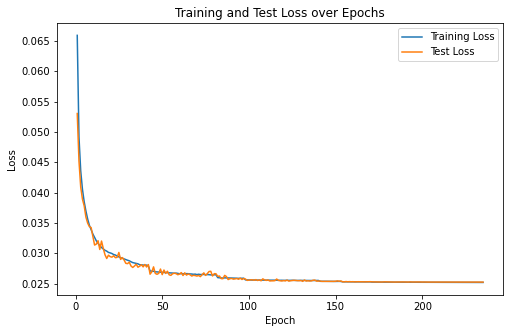

Early stopping triggered


In [8]:
%matplotlib inline

train_losses = []
test_losses = []
best_test_loss = float('inf')

early_stopping_patience = 20
patience_counter = 0

weight = 3.0

def l1_regularizer(model, lambda_l1=0.001):
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    return lambda_l1 * l1_norm

for epoch in range(num_epochs):
    model.train()

    train_loss = 0
    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}") as pbar:
        for batch_x, batch_y in pbar:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device) 

            optimizer.zero_grad()  

            reg_loss = weight * torch.norm(batch_y[:, 1] - batch_x[:, -1], p=2) if include_prev_action else 0 # Penalizing the steering angle/difference

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            total_loss = loss + reg_loss + l1_regularizer(model, lambda_l1=1e-4)
            
            total_loss.backward()  
            optimizer.step() 

            train_loss += loss.item()  
            
    avg_train_loss = train_loss / len(train_loader)  
    train_losses.append(avg_train_loss)

    # Clear output and print training loss
    clear_output(wait=True)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.5f}')
    
    # Evaluation phase
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
    
    avg_test_loss = total_loss / len(test_loader)  # Average test loss for the epoch
    test_losses.append(avg_test_loss)

    # Step the learning rate scheduler based on test loss
    scheduler.step(avg_test_loss)

    print(f'Test Loss: {avg_test_loss:.5f}')

    # Check if the test loss improved (early stopping)
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        patience_counter = 0
        # Save the model with the best test loss
        torch.save(model.state_dict(), './Model/model_noisy_45_64.pth')
        torch.save(model.state_dict(), '/home/la-user/ros2_ws/src/racecar_nn_controller/racecar_nn_controller/models/model_noisy_45_64.pth')
    else:
        patience_counter += 1

    # Plot training and test losses
    plt.close("all")
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epoch + 2), train_losses, label='Training Loss')
    plt.plot(range(1, epoch + 2), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss over Epochs')
    plt.legend()
    plt.show()
    plt.pause(0.001)

    # Early stopping based on patience
    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered")
        break


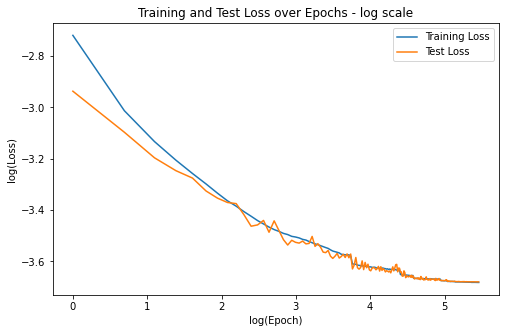

In [9]:
plt.close("all")
plt.figure(figsize=(8, 5))
plt.plot(np.log(range(1, epoch+2)), np.log(train_losses), label='Training Loss')
plt.plot(np.log(range(1, epoch+2)), np.log(test_losses), label='Test Loss')
plt.xlabel('log(Epoch)')
plt.ylabel('log(Loss)')
plt.title('Training and Test Loss over Epochs - log scale')
plt.legend()
plt.show()
plt.pause(0.001)